# How to delta hedge an option: Part III

## Monte Carlo simulations & replication scatterplots

In a previous article we went through the basics of what an option is, why you would buy it and built the basic foundations of what impacts its price through the argument of replication - rather than through distributional arguments requiring maths and formulae littered everywhere.

Here the aim is to continue in that vain of thought, but with a bit more practical stuff. The conclusion of the previous article was that through continuously re-balancing our delta hedge we can turn a call option from something that depends on where the underlying stock price finishes ('in the money' (ITM) vs 'out of the money' (OTM)) into something where what we really care about is how much the stock price _moves_ (up or down) during the life of the option - the volatility of the stock price.

But we also left a huge array of questions unanswered - most of which will probably remain unanswered here. Again in the interest of simplicity we will ignore things that complicate the picture (for now) and continue to focus on this idea of delta hedging. The aim here is to answer questions like:
 - where did we get that 'delta' number from - the sensitivity of the option price to the underlying stock price?
 - when we say re-balancing, how often should we do this and does it matter?
 - what if we use the wrong delta number consistently? What impacts whether this matters?

We will build a Monte Carlo engine for stock prices and then implement what we have just said - write some logic to simulate the delta hedging replication behaviour we have discussed and see if it actually works. Seeing is believing after all.

## Monte Carlo

This is just (for me anyway) a fancy way of saying 'simulator'. I'm sure there are more technically correct definitions but this one works for me. First things first if we want to simulate a load of _option_ prices through time then we need to simulate a load of _stock_ prices through time. To do this we will use python and in particular NumPy as we will be doing a lot with vectors.

There's a load more info here (more pretty graphs and intuitive explanations I promise) on why we choose to simulate stock price time series this way but if you are happy with it then we will just state the following. We will assume that stock _returns_ (not prices) come from a Normal Distribution and each return per time increment (we will base our time increments as days) is given by:

$$ r_t = ln(\frac{S_t}{S_{t-1}}) = \frac{r}{T} + \frac{\sigma}{\sqrt{T}} \epsilon_t \ \ \ , \epsilon_t \sim N(0,1) $$

In simple terms the 'log return' is given by some constant component, `r/T`, plus some random component, `epsilon`, where the random component has a scaling in front of it to decide how volatile we want our stock return process to be.

Based on the above we can see that we really have 2 'parameters' to control our stock price series - the systematic return component (or 'drift'), `r`, and the volatility of the returns given by `sigma`. Both of these numbers we will define as annual quantities and then appropriately scale them if we don't want annual returns but e.g. daily returns. The scaling nature is why we have `T` appearing in our equation.

Again, if you want to understand the nuts and bolts of this then pop over here - I think it makes everything really clear (disclaimer: I wrote it).

## Write the python

Alright so that's how we will define a given stock price return on a given day - now let's build something a bit more useful for examining our delta hedging purposes. To examine the efficacy of delta hedging we would probably like:
 - lots of potential paths to illustrate what happens if we end up way ITM or OTM etc
 - each path to have multiple time points for us to re-balance our delta hedge along the way

Given that there are roughly `252` business (trading) days in a year then we will define each stock price series as an 'annual' series consisting of `252` steps (or days). We then have `252` days to re-balance our delta hedge and then compare at the end how our replication performed vs the theoretical terminal payoff - the 'hockey stick' graphs.

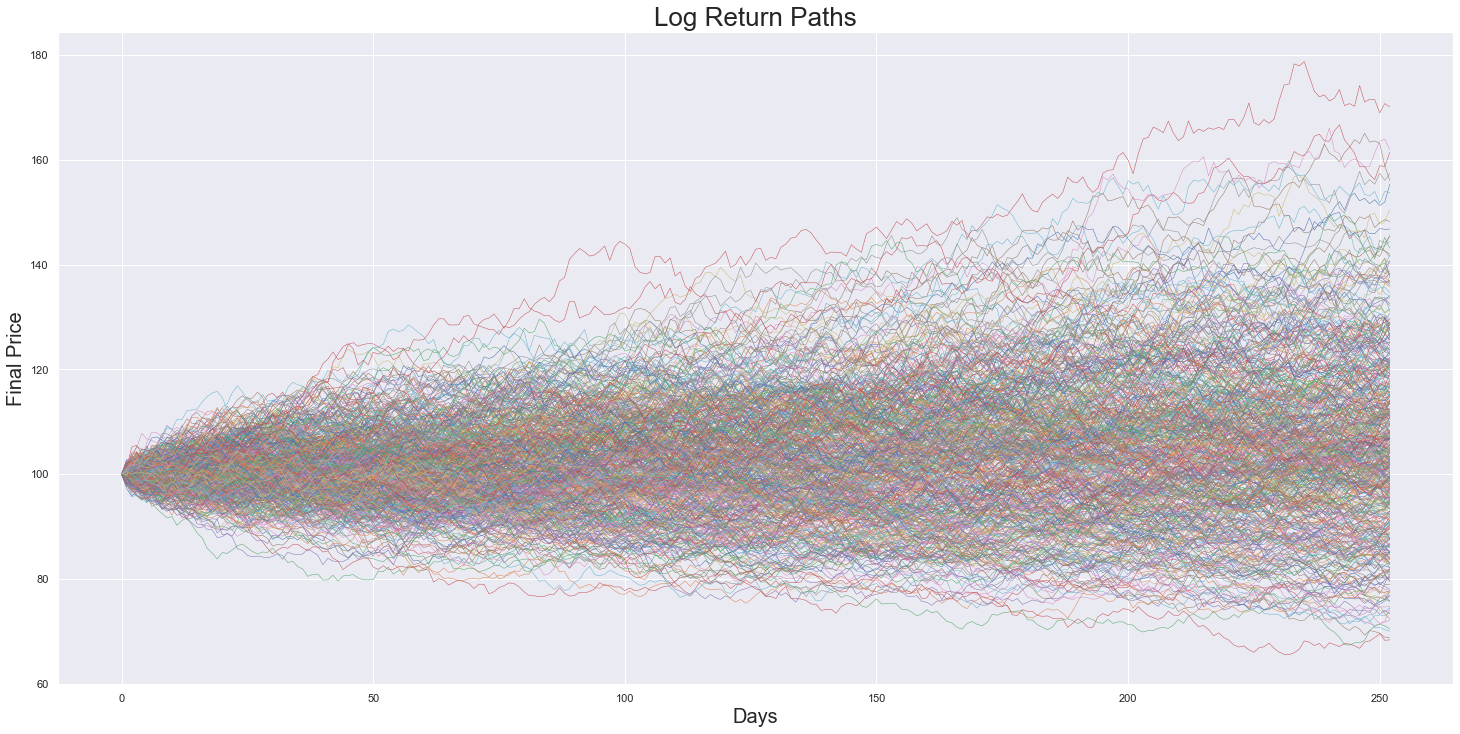

In [32]:
# import the usual suspects
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set() 


# function to generate the stock price series
def generate_paths(spot, drift, sigma, years, points, sims):
    
    # create numpy PCG PRNG
    rng = np.random.default_rng(seed=123)
    # create random numbers
    dW = rng.normal(size=(sims, points * years))
    # get our scaled random deviations
    scaled_dW = dW * (sigma / points**0.5)
    # add on the drift
    daily_devs = (drift / points) + scaled_dW
    # cumsum them as log returns additive
    cum_rets = np.cumsum(daily_devs, axis=1)
    # add in 0 at start for starting price
    cum_rets = np.insert(cum_rets, 0, 0, axis=1)
    # create price series
    pxs = spot * np.exp(cum_rets)
    
    return daily_devs, pxs


# determine our process parameters
px = 100
sigma = 0.16
risk_free = 0.05
divs = 0.00

# determine our sim settings
# i.e. we want 10,000 sets of 252 random numbers
sims = 10000
points = 252
years = 1

# churn out sims
rets, pxs = generate_paths(px, risk_free - divs, sigma, years, points, sims)

# plot them
fig, ax = plt.subplots(figsize=(25,12))

for p in pxs[:500]:
    ax.plot([z for z in range(0, points*years+1)], p, linewidth=0.5)
    
ax.set_title('Log Return Paths', fontsize=26)
ax.set_xlabel('Days', fontsize=20)
ax.set_ylabel('Final Price', fontsize=20);

Okay great - the above shows a selection of the `10,000` series we have simulated with the stock price on the y-axis and the `253` days (`252` days plus `1` starting day) on the x-axis. We now have a load of underlying stock price series that we can use to:
 - value an option on at each point in time
 - compare this value to the value of our delta-hedged replication strategy
 - understand if delta-hedging is all its cracked up to be

Not to confuse things but it's quite nice to define this stock price generation process separately. It means if we want to use a different set of assumptions to create our price simulations (e.g. log returns not normally distributed but maybe slightly more fat tailed) then we can without impacting the replication process.

## Where is this delta number coming from?

Time to finally explain where this magic number comes from. In the previous article it was stated to just be the slope of the payoff graph of the (call) option as per below:

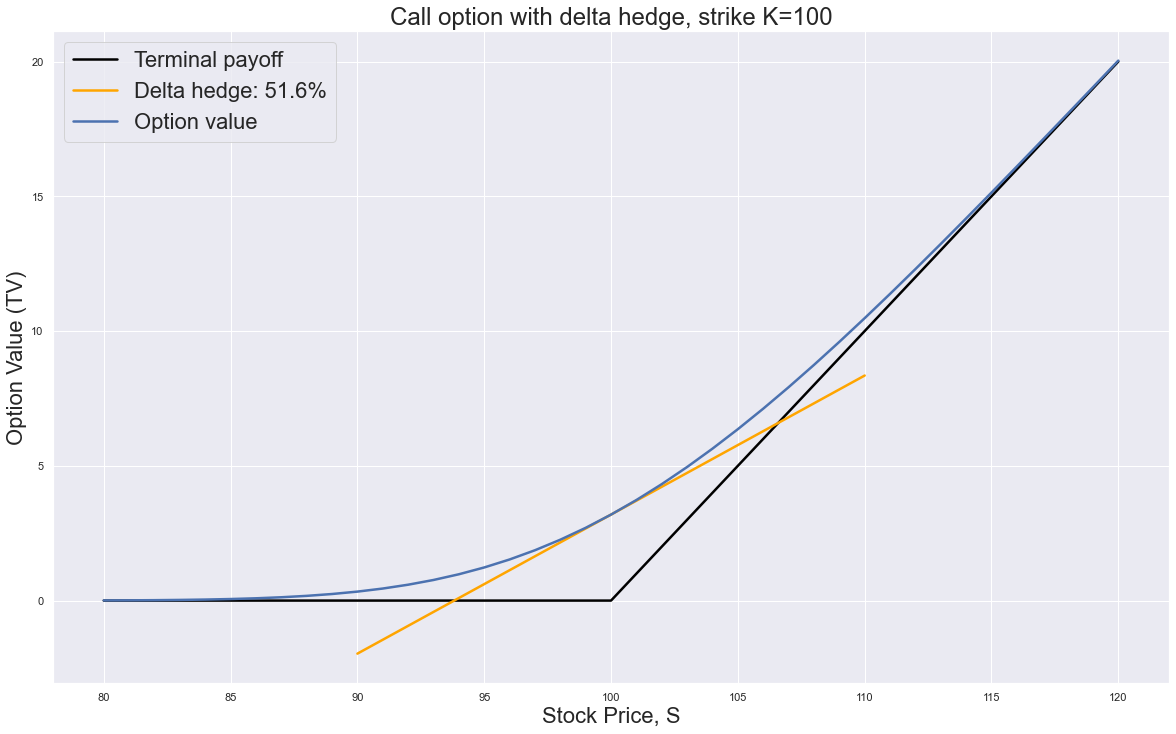

In [33]:
# functions to compute Black-Scholes option prices
def bs_d_one_simple(S, K, sigma, delta_T):
    
    return (1 / (sigma * delta_T**0.5)) * (np.log(S / K) + (sigma**2)/2 * delta_T)

def compute_prices_simple(pxs, K, sigma, T, call=True):
    
    # calculate d1 and d2
    d_one = bs_d_one_simple(pxs, K, sigma, T)
    d_two = d_one - sigma * T**0.5
    # compute deltas and prices
    if call:
        deltas = stats.norm.cdf(d_one)
        prices = pxs * deltas - stats.norm.cdf(d_two) * K
    else:
        deltas = stats.norm.cdf(d_one) - 1
        prices = stats.norm.cdf(-d_two) * K + deltas * pxs
    
    return prices, deltas

K = 100
sigma = 0.16
demo_pxs = np.linspace(80, 120, 41)

call_pnls = [max(0, s - K) for s in demo_pxs]
op_pxs = compute_prices_simple(demo_pxs, K, sigma, 0.25, call=True)
delta_hedge = [op_pxs[0][20] + op_pxs[1][20]* (p - 100) for p in np.linspace(90, 110, 21)]

fig, ax = plt.subplots(figsize=(20,12))

ax.plot(demo_pxs, call_pnls, lw=2.5, color='black', label='Terminal payoff')
ax.plot(np.linspace(90, 110, 21), delta_hedge, lw=2.5, color='orange', label='Delta hedge: {:.1%}'.format(op_pxs[1][20]))
ax.plot(demo_pxs, op_pxs[0], lw=2.5, label='Option value')

ax.set_title('Call option with delta hedge, strike K={}'.format(K), fontsize=24)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Option Value (TV)', fontsize=22)
ax.legend(fontsize=22);

But we never said _what_ function gives the graph it's shape. All we did was use some logic to set some _bounds_ on how this function should look. We used logic to set bounds like:
 - it should converge to the terminal 'hockey stick' graph at the extremes and so have a delta of `0` way OTM and `1` way ITM
 - it should flow smoothly from these extremes
 - as time passes it should 'decay' toward the terminal payoff and become more kinked at the option strike `K`

But that then leaves a lot to be explained - small differences in this delta number can make huge differences in money made ('PnL' - profit and loss) over time for large trading desks. In order to generate this number we need a model - a model that we put in some assumptions to generate the answer to the fundamental question of what delta is:

_"What happens to the value of our option when the stock price moves?"_

This is where things can get very very complicated. In practise this is where you start to get into technical details like:
 - does it change symmetrically for an up move and a down move?
 - what sizes of moves should we use to compute the change if we use first differences to compute it? `0.5%` each way? `1%` each way?
 - are there other factors that impact the option's price that will change when the stock price moves? If the stock price moves would we expect the 'implied volatility' to change as well? Can we incorporate this 'expected' change into our model?

For simplicity we will stick with the simple solution: __the Black-Scholes delta__. The whole argument of being able to value an option through continuous delta hedged replication is the core assumption of the Black Scholes model (along with a whole host of others). The aim here is not to get into the pros and cons of it but just to state that we will use it.

## What is Black-Scholes?

There are honestly libraries full of this stuff but let's stick with a bare bones explanation just to gleam the info we need for this delta-hedging simulation experiment. Black-Scholes got credit for coming up with the following option valuation formula based on the argument of continuous delta-hedged replication. The idea was that if you _continuously_ (saying this word a lot) re-balance your delta then an option can be reduced to a riskless combination of:
 - stock: the stock we hold as our delta hedge at each moment in time
 - cash: cash we may need to borrow to buy our delta hedge or generate from delta-hedging activity etc etc

__If as we saw the value of an option depends on how volatile the stock price is during its lifetime, and stock prices (and their volatilities) and very unpredictable, then how on earth can this be a _riskless_ replication?__

Great question. But the answer from the model is simple - nah, don't worry about that; the volatility of the stock price in the model is _constant_. It's like it's some known factor that we input. In practise we don't use some sort of volatility forecasting model to come up with the volatility input but instead _infer_ it from market prices - this is why it is called '_implied_ volatility'. Because given:
 - the other Black-Scholes formula inputs inferred from other financial instruments (interest rates from Treasury bonds, divs from div swap markets etc)
 - the option prices in the market

there is only one parameter remaining to line up to those market option prices - the volatility parameter which we can then back out from the formula.

## The formula

Let's just state it here and do very little explaining. This is the formula we will be using to value our options at each moment in time in each simulation:

$$ C(S_t, t) = N(d_1) S_t - N(d_2) K e^{-r(T-t)} $$

where we define:

$$ d_1 = \frac{1}{\sigma \sqrt{T-t}} [ln(\frac{S_t}{K}) + (r + \frac{1}{2} \sigma^2) (T - t))] $$

and then:

$$ d_2 = d_1 - \sigma \sqrt{T-t}  $$

## The delta

Using this formula we can then take the first derivative of it to get the sensitivity of the option price when the underlying stock price moves - the delta (nice derivation [here](https://quantpie.co.uk/bsm_formula/bs_delta.php) if you fancy it):

$$ \delta = N(d_1) $$

We're not going to get in to any explanation of this for now because it will just bog us down but if we accept it for now we can come back to it and critique it later. Again, we not stating that this is the way the world works, we're just stating that this is _a_ version of the world and then we can test that if we create the version of the world which this model is based on (almost continuous delta re-hedging, normally distributed log returns etc) that it works.

## Option prices

So now we have a formula for each of:
 - the option value at each moment in time
 - the delta of that option at each moment in time

let's feed in our simulated stock prices and spit out for each price series at each moment in time these computed quantities. Once we've got them we can then plot a few of them vs the prices at various points throughout the year (our `252` days) and see if it lines up with what we drew out before.

In [21]:
def bs_d_one(S, K, rf, div, sigma, delta_T):
    
    return (1 / (sigma * delta_T**0.5)) * (np.log(S / K) + (rf - div + (sigma**2)/2) * delta_T)

def compute_prices(pxs, K, rf, div, sigma, points, years, call=True, hedge_vol=None):
    
    # create time vector
    times = np.linspace(0, years, (points*years) + 1)[::-1]
    # calculate d1 and d2
    d_one = bs_d_one(pxs, K, rf, div, sigma, times)
    d_two = d_one - sigma * times**0.5
    # compute deltas and prices
    if call:
        deltas = stats.norm.cdf(d_one)
        prices = pxs * np.exp(-div * times) * deltas - stats.norm.cdf(d_two) * K * np.exp(-rf * times)
        gammas = stats.norm.pdf(d_one) / (pxs * sigma * np.sqrt(times))
        
        if hedge_vol:
            d_one = bs_d_one(pxs, K, rf, div, hedge_vol, times)
            deltas = stats.norm.cdf(d_one)
            gammas = stats.norm.pdf(d_one) / (pxs * hedge_vol * np.sqrt(times))
    else:
        deltas = stats.norm.cdf(d_one) - 1
        prices = stats.norm.cdf(-d_two) * K * np.exp(-rf * times) + deltas * pxs * np.exp(-div * times)
        gammas = stats.norm.pdf(d_one) / (pxs * sigma * np.sqrt(times))
        if hedge_vol:
            d_one = bs_d_one(pxs, K, rf, div, hedge_vol, times)
            deltas = stats.norm.cdf(d_one) - 1
            gammas = stats.norm.pdf(d_one) / (pxs * hedge_vol * np.sqrt(times))
    
    return prices, deltas, gammas


risk_free = 0.05
divs = 0.00
sigma = 0.16
K = 100
call=True

# churn out sims
rets, pxs = generate_paths(px, risk_free - divs, sigma, years, points, sims)
# cvhurn out option tvs, deltas and gammas
call_pxs, deltas, gammas = compute_prices(pxs, K, risk_free, divs, sigma, points, years, call=call)

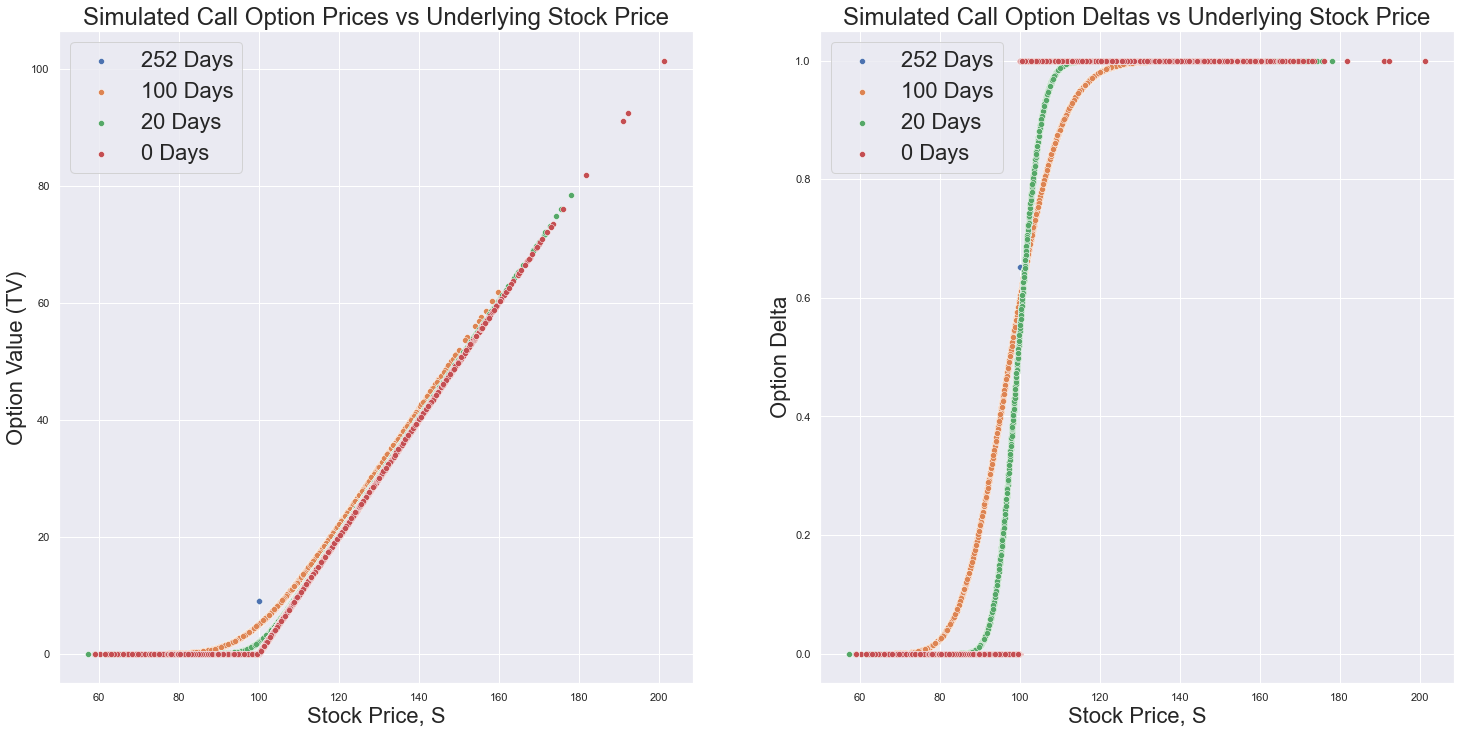

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 12))
axes = axes.reshape(-1)

ts = [-253, -101, -21, -1]

for t in ts:
    
    prices = pxs[:,t]
    call_prices = call_pxs[:,t]
    call_deltas = deltas[:,t]
    
    sns.scatterplot(prices, call_prices, ax=axes[0], label="{} Days".format(-t-1))
    sns.scatterplot(prices, call_deltas, ax=axes[1], label="{} Days".format(-t-1))

axes[0].set_title('Simulated Call Option Prices vs Underlying Stock Price', fontsize=24)
axes[0].set_xlabel('Stock Price, S', fontsize=22)
axes[0].set_ylabel('Option Value (TV)', fontsize=22)
axes[0].legend(fontsize=22)

axes[1].set_title('Simulated Call Option Deltas vs Underlying Stock Price', fontsize=24)
axes[1].set_xlabel('Stock Price, S', fontsize=22)
axes[1].set_ylabel('Option Delta', fontsize=22)
axes[1].legend(fontsize=22);

So things are looking good. We have the graph on the left showing the simulated option prices at various points in time vs the simulated stock price. The red spots show how this looks at expiry when we have zero time left. The blue dot shows that all simulated stock prices start at `100` and so they all have the same call option price, and then the other lines show us somewhere in between.

On the right hand side we then have the option delta at the same various points in time and this also lines up with what we had before - the values move smoothly from `0` to `1` except for when we have zero time left to expiry when it jumps from `0` to `1`. But this is expected and lines up with what we see in the call option price graph - we have a kink at the strike `K` that takes us from a flat line to a line with a slope of `1` when there is no time left to expiry. So far so good.

The option values (or 'TVs' - theoretical values) will serve as our benchmark to see if the delta-hedged replications are working and we will create these delta hedged portfolios using the deltas we have churned out to form the graph on the right.

## Let's get hedging

It's quite commonly just stated "yeah you know the way to hedge an option under Black-Scholes is _just_ to hold some quantity of stock and some cash". Sounds simple. Although in reality it's this last bit that gets fiddly. The idea is that at each point in time we will have an option value spit out from the above formula and we want a 'portfolio' of:
 - stock
 - cash

s.t. we match up with this value (or maybe _on average_ match up with this value). The value of the stock is the easy bit - we just take the stock we hold (dictated to us by the delta formula above) and multiply that by the value of each of those stocks - just the current stock price `S`. The code is very very simple:

In [23]:
# compute stock values at each point in time
stock_values = pxs * deltas

But the cash component is trickier to keep track of. If we take the example where we _sell_ a call option and so need to go about replicating it using delta hedging, our first steps are:
 - sell the option: we receive some cash for this (yay!!!)
 - buy the delta hedge: we probably haven't received enough money from the premium to cover this so we need to borrow some cash to buy all the stock we need

But then as time progresses things get a bit trickier - after our first day out there hedging we will then have to:
 - rebalance delta hedge: this may require us to borrow more to buy more stock or sell some stock and generate some cash
 - pay interest: if we have borrowed to fund our delta hedge then we probably need to pay some interest on that - this is yet another cash flow
 - receive dividends: we will ignore this one for now but this would be yet another source of cash

and all of this needs managed through time assuming that whatever cash balance we have at each moment we are either investing and receiving the risk free rate `r` on it, or borrowing and so paying that risk free rate. Below is the implementation of this using as much NumPy as possible to prevent unnecessary loops.

In [24]:
# compute cash flows from various activities
# at each point we will add on cash flows to the future valued version
# of last period's cash balance - this gives us our new cash balance

# cash flow from delta hedging
# compute cash generated from delta re-hedging
delta_chgs = np.diff(deltas, axis=1)
delta_rehedge_cfs = -delta_chgs * pxs[:,1:]

# compute dividend income
div_cfs = deltas[:,:-1] * pxs[:,:-1] * divs / points

# compute starting premium and delta cfs
start_cbs = call_pxs[:,0] - deltas[:,0] * pxs[:,0]

# init our cash balance and cashflow arrays
cbs = [start_cbs]
cfs = [np.zeros(sims)]

for drh, dcf in zip(delta_rehedge_cfs.T, div_cfs.T):
    
    # get previous cash balance
    prev_cash = cbs[-1]
    # future value it
    new_cash = prev_cash * (1 + risk_free / points)
    # add on new cash flows
    cf = drh + dcf
    cb = new_cash + cf
    cfs.append(cf)
    cbs.append(cb)

cfs = np.array(cfs).T
cbs = np.array(cbs).T

Now that we should have for each simulation at each point in time:
 - a value of our delta hedge (stock portion of portfolio)
 - a value of our running cash balance

we can do what we did before - at various snapshots sum these values and see how this looks - especially in comparison to the theoretical call option value we are supposed to be replicating.

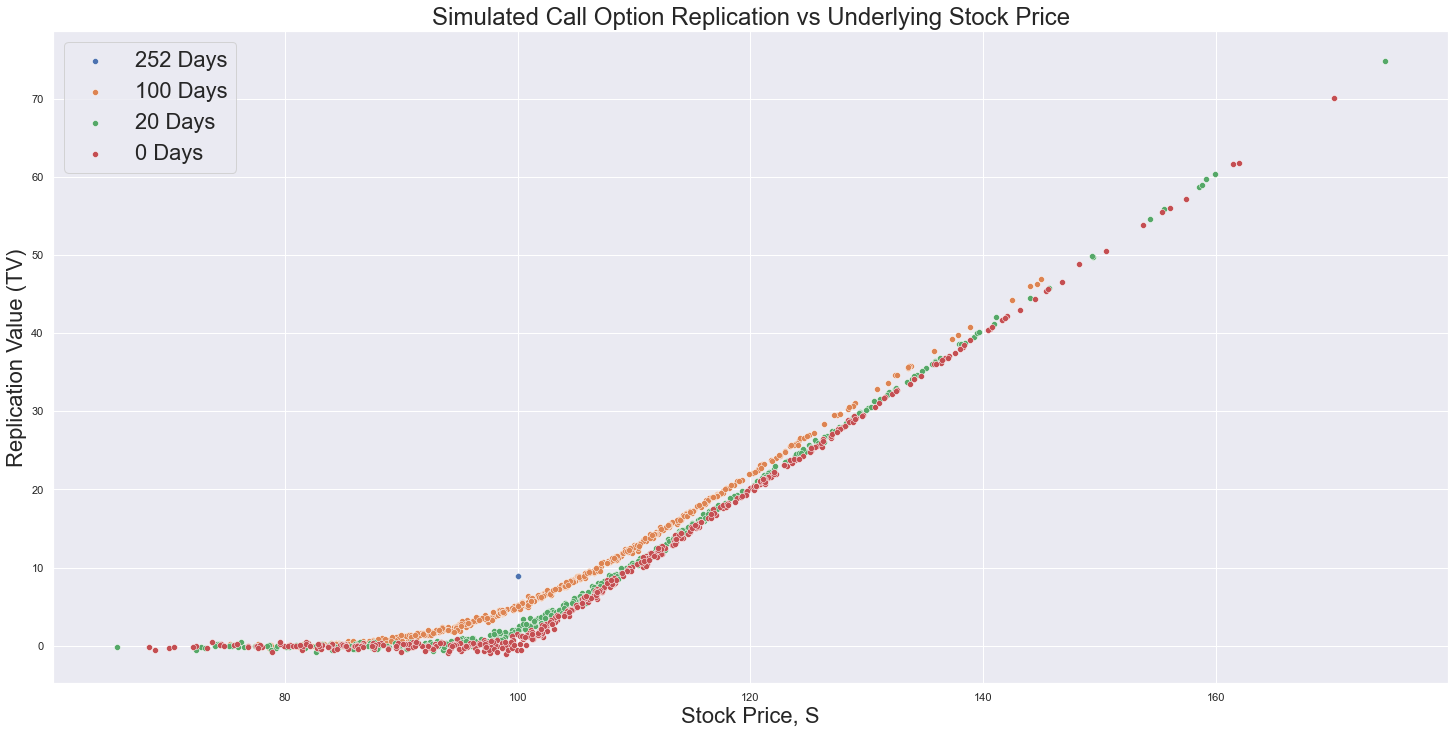

In [25]:
fig, ax = plt.subplots(figsize=(25, 12))

ts = [-253, -101, -21, -1]

for t in ts:
    
    prices = pxs[:500, t]
    repl_pxs = cbs[:500, t] + stock_values[:500, t]
    
    sns.scatterplot(prices, repl_pxs, ax=ax, label="{} Days".format(-t-1))

ax.set_title('Simulated Call Option Replication vs Underlying Stock Price', fontsize=24)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Replication Value (TV)', fontsize=22)
ax.legend(fontsize=22);

Quite sexy. So it looks like it's working!!! The sum of the replication components seems to line up pretty well with the theoretical option value. Sure, it's a bit noisier than the replication (the dots are a bit scattered around) but overall it looks pretty great.

## Recap

It's worth reviewing what we've established here. Under the assumptions that we've imposed on our simulations (normally distributed returns, constant variance process etc etc) it looks like:
 - through holding a portfolio of just cash and the underlying stock we can replicate the payoff of a call option
 - the amount of stock we should hold is dictated to us by the delta of the Black-Scholes model
 - there is some noise in the hedging process but _on average_ it seems to line up

In the next article let's have a look at what happens if we look into that variation. What happens if we hedge more or less often? Why is it that sometimes we have a positive hedging error vs other times we lose money on the replication (vs the theoretical payoff)?